In [77]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline



import os, math
import joblib
from joblib import Parallel, delayed
from collections import Counter, defaultdict

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import cvxpy as cp
import networkx as nx
import torch, wandb

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans


import pytorch_lightning as pl
pl.utilities.seed.seed_everything(seed=0)

import matplotlib
from matplotlib import rc, ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

rc('text', usetex=True)
rc('font', family='serif')

# OWN MODULES
from src.data.data_module import UNOSDataModule, UKRegDataModule, UNOS2UKRegDataModule
from src.models.organsync import OrganSync_Network

In [1]:
# DATA PARAMS
data = 'UKreg'
batch_size = 256
synth=False
n_models=1
# MODEL PARAMS
sweep_name='qhybu27g'
# sweep_name UKReg (ss):   u6yduuey
# sweep_name U2U (ss):     pfkuu2l6
# sweep_name UKreg (fact): kafit9ga
# sweep_name U2U (fact):   qhybu27g


# LOAD DATA
if data == 'UNOS':
    project = 'organsync-net'
    data_dir = '../data/processed'
    dm = UNOSDataModule(data_dir, batch_size=batch_size, is_synth=synth)
elif data == 'U2U':
    project = 'organsync-net-u2u'
    data_dir = '../data/processed_UNOS2UKReg_no_split'
    dm = UNOS2UKRegDataModule(data_dir, batch_size=batch_size, is_synth=synth)
    dm.prepare_data()
else:
    project = 'organsync-net-ukreg'
    data_dir = '../data/processed_UKReg/clinical_ukeld_2_ukeld'
    dm = UKRegDataModule(data_dir, batch_size=batch_size, is_synth=synth)
    dm.prepare_data()

dm.setup(stage='test')
dm.setup(stage='fit')    

# LOAD MODELS
api = wandb.Api()
sweep = api.sweep(path=f'jeroenbe/{project}/{sweep_name}')
                
summary_list = []
for run in sweep.runs:
    d = run.summary._json_dict
    d['id'] = run.id
    summary_list.append(d)
                        

summary_df = pd.DataFrame.from_records(summary_list)
model_ids = summary_df.nsmallest(n=n_models, columns=['test_loss (synth) - RMSE']).id.to_numpy().astype(str)

models = dict()
for model_id in model_ids:
    try:
        params = wandb.restore(f'organsync_net.ckpt.ckpt', run_path=f'jeroenbe/{project}/{model_id}', replace=True)
    except:
        params = wandb.restore(f'organsync_net.ckpt-v0.ckpt', run_path=f'jeroenbe/{project}/{model_id}', replace=True)
    
    models[model_id] = OrganSync_Network.load_from_checkpoint(params.name).double()

NameError: name 'UKRegDataModule' is not defined

In [91]:
# BUILD PATIENT CLUSTERS

resolution_k = 10            # NOTE: also used for bipartite size
n_per_cluster = 30           # NOTE: limit computation
test_length = len(dm.test_dataloader().dataset)
train_length = len(dm.train_dataloader().dataset)

X, O, Y, _ = dm.train_dataloader().dataset.dataset.tensors
X_test, O_test, Y_test, _ = dm.test_dataloader().dataset.tensors
XO = torch.cat((X, O), dim=1)

cluster_x = KMeans(n_clusters=resolution_k)
cluster_xo= KMeans(n_clusters=resolution_k)

cluster_x.fit(X)
cluster_xo.fit(XO)

print('Size of c(X):', Counter(cluster_x.labels_))
print('Size of c(XO):', Counter(cluster_xo.labels_))

Size of c(X): Counter({1: 2650, 3: 2600, 2: 1967, 4: 1523, 8: 1495, 0: 1401, 9: 1216, 5: 1158, 6: 421, 7: 7})
Size of c(XO): Counter({0: 2850, 8: 2775, 9: 1684, 4: 1642, 3: 1541, 6: 1466, 1: 1234, 5: 797, 2: 442, 7: 7})


In [45]:
# SELECT PATIENTS FROM CLUSTERS
# this is done on the test set

cluster_labels = np.arange(0, resolution_k, 1)

patients_x = np.empty((0, n_per_cluster), dtype=int)   # INFO: each index corresponds with a label
patients_xo = np.empty((0, n_per_cluster), dtype=int)  #   for each label, we sample 20 patients.
                                                       #   This is to limit computation, more can 
                                                       #   be sampled, though 200 patients is likely 
                                                       #   enough.
            
X_test, O_test,_,_ = dm.test_dataloader().dataset.tensors
test_cluster_labels_x = cluster_x.predict(X_test)  
test_cluster_labels_xo= cluster_xo.predict(torch.cat((X_test, O_test), dim=1))

for label in cluster_labels:
    patients_of_label_x = np.where(test_cluster_labels_x == label)[0]
    patients_in_label_x = patients_of_label_x[np.random.randint(0, len(patients_of_label_x), (n_per_cluster,))]
    
    patients_of_label_xo = np.where(test_cluster_labels_xo == label)[0]
    patients_in_label_xo = patients_of_label_xo[np.random.randint(0, len(patients_of_label_xo), (n_per_cluster,))]
    
    patients_xo = np.append(patients_xo, patients_in_label_xo.reshape(1, -1), axis=0)
    patients_x = np.append(patients_x, patients_in_label_x.reshape(1, -1), axis=0)

    

In [46]:
# FOR EACH MODEL BUILD U
# this is done on the training set

n = 300      # limit compute
U = dict()   # representation

for k in models.keys():
    indxs = torch.randint(0, len(X), (n,))
    catted = torch.cat((X[indxs], O[indxs]), dim=1).double()
    U_labels_x = cluster_x.predict(X[indxs])
    U_labels_xo = cluster_xo.predict(catted)

    with torch.no_grad():
        representation = models[k].representation(catted)
    
    U[k] = representation


In [47]:
# PER CLUSTER, PER MODEL BUILD u

# new pair representation per model -> (resolution_k, n_per_cluster, dim(u))
u_x = {k: np.empty((0, n_per_cluster, models[k].output_dim)) for k in models.keys()}
u_xo = {k: np.empty((0, n_per_cluster, models[k].output_dim)) for k in models.keys()}


# REPRESENT X
for ps in patients_x:

    x, o, _, _ = dm.train_dataloader().dataset.dataset[ps]
    pair = torch.cat((x, o), dim=1)
    
    with torch.no_grad():
        for k in models.keys():
            representation = models[k].representation(pair).view(1, n_per_cluster, -1)
            u_x[k] = np.append(u_x[k], representation, axis=0)

# REPRESENT XO
for ps in patients_xo:
    x, o, _, _ = dm.train_dataloader().dataset.dataset[ps]
    pair = torch.cat((x, o), dim=1)

    
    with torch.no_grad():
        for k in models.keys():
            representation = models[k].representation(pair)
            u_xo[k] = np.append(u_xo[k], representation.view(1, n_per_cluster, -1), axis=0)


In [48]:
# PER CLUSTER, PER MODEL COMPUTE a
# NOTE: this cell comprises the bulk of 
#   the computation; might run long.


lambda_ = .1


# a_s per model -> (resolution_k, n_per_cluster, len(U)) => per (cluster, patient, a_s)
A_s_x = {k: np.empty((0, n_per_cluster, n)) for k in models.keys()} 
A_s_xo = {k: np.empty((0, n_per_cluster, n)) for k in models.keys()} 


def convex_opt(u, U, lambd):
    a = cp.Variable(U.shape[0])

    objective = cp.Minimize(cp.norm2(a@U - u)**2 + lambd * cp.norm1(a))
    constraints = [0 <= a, a <= 1, cp.sum(a) == 1]
    prob = cp.Problem(objective, constraints)

    _ = prob.solve(warm_start=True, solver=cp.SCS)

    return a.value


print('-- STARTING --')
print('---- CVX OPT for X')
for k in u_x.keys():
    for u_s_in_cluster in u_x[k]:
        a = Parallel(n_jobs=joblib.cpu_count())(delayed(convex_opt)(u_, U[k], lambda_) for u_ in u_s_in_cluster)
        A_s_x[k] = np.append(A_s_x[k], np.array(a)[:].reshape(1, n_per_cluster, -1), axis=0)
    print(f'------ finished model {k}')
        
        

print('---- CVX OPT for XO')
for k in u_xo.keys():
    for u_s_in_cluster in u_xo[k]:
        a = Parallel(n_jobs=joblib.cpu_count())(delayed(convex_opt)(u_, U[k], lambda_) for u_ in u_s_in_cluster)
        A_s_xo[k] = np.append(A_s_xo[k], np.array(a)[:].reshape(1, n_per_cluster, -1), axis=0)
    print(f'------ finished model {k}')
print('-- FINISHED --')


-- STARTING --
---- CVX OPT for X
------ finished model cg7zrn5o
------ finished model uogcw8r3
------ finished model a2sjqtps
------ finished model 8dda7lq2
------ finished model 8tax5bnb
------ finished model xjqvriqc
------ finished model 9nfnjfaj
------ finished model ltf6hdov
------ finished model 8298slm5
---- CVX OPT for XO
------ finished model cg7zrn5o
------ finished model uogcw8r3
------ finished model a2sjqtps
------ finished model 8dda7lq2
------ finished model 8tax5bnb
------ finished model xjqvriqc
------ finished model 9nfnjfaj
------ finished model ltf6hdov
------ finished model 8298slm5
-- FINISHED --


In [49]:
# BUILD MATRIX FROM a
#    INFO: every cluster connects to every other cluster.
#      On each row, there is the amount of the column
#      the cluster has on other clusters.
threshold = 1e-1 


M_x = np.empty((resolution_k, resolution_k))
M_xo= np.empty((resolution_k, resolution_k))


# X
combined_x = np.array(list(A_s_x.values()))

# filtered = [models, clusters, patients, a]
filtered_x = np.where(combined_x > threshold, combined_x, np.zeros(combined_x.shape))

for i, r in enumerate(M_x):
    one_model_sample = np.repeat(U_labels_x[np.newaxis, :], n_per_cluster, axis=0)
    more_model_sample= np.repeat(one_model_sample[np.newaxis, :, :], n_models, axis=0)

    sample = more_model_sample[filtered_x[:,i,:,:].astype(bool)]

    unique, counts = np.unique(sample, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    
    M_x[i, list(label_distribution.keys())] = list(label_distribution.values())

M_x = normalize(M_x, axis=1, norm='l1')
        

# XO
combined_xo = np.array(list(A_s_xo.values()))

# filtered = [models, clusters, patients, a]
filtered_xo = np.where(combined_xo > threshold, combined_xo, np.zeros(combined_xo.shape))

for i, r in enumerate(M_xo):
    one_model_sample = np.repeat(U_labels_xo[np.newaxis, :], n_per_cluster, axis=0)
    more_model_sample= np.repeat(one_model_sample[np.newaxis, :, :], n_models, axis=0)

    sample = more_model_sample[filtered_xo[:,i,:,:].astype(bool)]

    unique, counts = np.unique(sample, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    
    M_xo[i, list(label_distribution.keys())] = list(label_distribution.values())

M_xo = normalize(M_xo, axis=1, norm='l1')
        


[Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')]


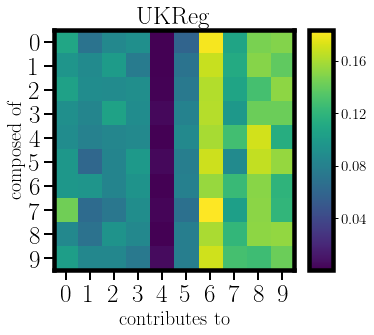

In [67]:
# PLOT MATRIX (XO)
def plot_matrix(m, require_colorbar, title):
    rc('axes', linewidth= 4.5) 

    require_colorbar = True

    fig, ax = plt.subplots(figsize=(5,5))

    ax.set_yticks(np.arange(0,10,1))
    ax.set_yticklabels(np.arange(0, 10, 1), fontsize=25)
    ax.set_xticks(np.arange(0,10,1))
    ax.set_xticklabels(np.arange(0, 10, 1), fontsize=25)

    ax.set_ylabel('composed of',  fontsize=20)
    ax.set_xlabel('contributes to',  fontsize=20)

    ax.tick_params(length=10, width=2)    

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    im = ax.imshow(m)

    divider = make_axes_locatable(ax)


    ax.set_title(title, fontsize=25)

    if require_colorbar:
        cax = divider.append_axes("right", size='10%', pad=.2)
        cax.tick_params(length=5, width=1)
        
        print(cax.yaxis.get_ticklabels())

        fig.colorbar(im, cax=cax, ticks=np.arange(0, .2, .04))
        cax.set_yticklabels(np.arange(0, .2, .04), fontsize=15)
        
    return fig

f = plot_matrix(M_xo, True, 'UKReg')

In [68]:
# SAVE FIGURE
# SAVE RESULTS
fig_detail='UKReg'


f.savefig(f'{fig_detail}_composition.pdf', bbox_inches = "tight")
np.save(f'{fig_detail}_M_xo', M_xo)
np.save(f'{fig_detail}_M_x', M_x)


In [ ]:
name='UKReg (semi-synth.)'

m_xo_unos = np.load(f'./{name}_M_xo.npy')
f = plot_matrix(m_xo_unos, True, name)
f.savefig(f'{name}_composition.pdf', bbox_inches = "tight")

In [62]:
f.colorbar?